In [9]:
# Netflix Data Analysis
# Import with version checks
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(f"Python: {sys.version.split()[0]}")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")

# Configuration
sns.set_theme()
pd.set_option('display.precision', 2)


Python: 3.13.5
Pandas: 2.3.1
NumPy: 2.3.2


In [22]:
def load_data():
    """Professional data loader with validation"""
    try:
        filepath = r'C:\Users\nandi\OneDrive\Desktop\project 9\netflix_analysis\data File.xlsx'

        
        nflx = pd.read_excel(filepath, sheet_name='NFLX Top 10', parse_dates=['week'])
        imdb = pd.read_excel(filepath, sheet_name='IMDB Rating')
        
        # Data quality assertions
        assert not nflx.empty, "NFLX data is empty"
        assert 'weekly_hours_viewed' in nflx.columns, "Critical column missing"
        
        return nflx, imdb
    except Exception as e:
        raise SystemError(f"Data loading failed: {str(e)}")


In [18]:
!pip install openpyxl



   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpy

In [24]:
nflx_raw, imdb_raw = load_data()
display(nflx_raw.head(2))   # For 'NFLX Top 10' sheet
display(imdb_raw.head(2))   # For 'IMDB Rating' sheet



,date_added,week,category,show_title,season_title,weekly_rank,cumulative_weeks_in_top_10,weekly_hours_viewed
0,2022-06-28,2022-06-26,Films (English),Hustle,NaN,3,3,26050000
1,2022-04-26,2022-04-24,TV (Non-English),Heirs to the Land,Heirs to the Land: Season 1,5,2,18840000


,title,rating
0,Bhool Bhulaiyaa,7.3
1,Trespass,5.3


In [25]:
# Filter outage week
nflx = nflx_raw[nflx_raw['week'] != pd.to_datetime('2022-05-22')].copy()

# Clean IMDb data
imdb = (
    imdb_raw[imdb_raw['rating'] > 0]
    .assign(rating=lambda x: x['rating'].clip(1, 10))
)

# Memory optimization
nflx['category'] = nflx['category'].astype('category')

In [26]:
# Q1: Most appearances
top_film = (
    nflx[nflx['category'] == 'Films (English)']
    ['show_title'].value_counts()
    .idxmax()
)
top_avg_hours = nflx[nflx['show_title'] == top_film]['weekly_hours_viewed'].mean()

# Q2: Lowest rating
merged = pd.merge(
    nflx[nflx['category'] == 'Films (English)'],
    imdb,
    left_on='show_title',
    right_on='title',
    how='inner'
)
worst_film = merged.loc[merged['rating'].idxmin()]

 Q1: Film with the Most Appearances
Title: Sonic the Hedgehog
Number of Weeks in Top 10: 7
Average Weekly Hours Viewed: 8550000.00 million

Q2: Film with the Lowest IMDb Rating
Title: 365 Days: This Day
IMDb Rating: 2.5
Average Weekly Hours Viewed: 38696666.67 million



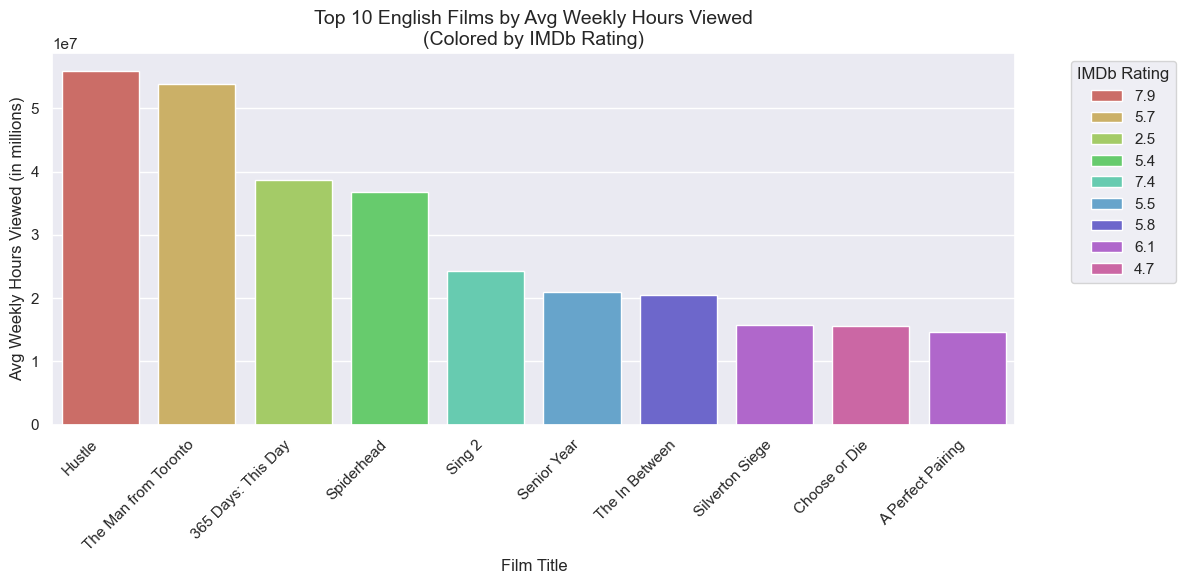

In [39]:
# 📌 Filter for English Films only
english_films = merged[merged['category'] == 'Films (English)']

# ✅ Q1: Film with the most appearances on Netflix Top 10
top_appearance = (
    english_films.groupby('show_title')
    .agg(
        appearances=('week', 'count'),
        avg_weekly_hours=('weekly_hours_viewed', 'mean')
    )
    .sort_values(by='appearances', ascending=False)
    .reset_index()
)

most_frequent_film = top_appearance.iloc[0]

print(" Q1: Film with the Most Appearances")
print(f"Title: {most_frequent_film['show_title']}")
print(f"Number of Weeks in Top 10: {most_frequent_film['appearances']}")
print(f"Average Weekly Hours Viewed: {most_frequent_film['avg_weekly_hours']:.2f} million\n")

# ✅ Q2:Film with the Lowest IMDb Rating
lowest_imdb = (
    english_films.groupby(['show_title', 'rating'])
    .agg(avg_weekly_hours=('weekly_hours_viewed', 'mean'))
    .sort_values(by='rating')
    .reset_index()
)

lowest_rated_film = lowest_imdb.iloc[0]

print("Q2: Film with the Lowest IMDb Rating")
print(f"Title: {lowest_rated_film['show_title']}")
print(f"IMDb Rating: {lowest_rated_film['rating']}")
print(f"Average Weekly Hours Viewed: {lowest_rated_film['avg_weekly_hours']:.2f} million\n")

# ✅ Q3: Top 10 English Films by Average Weekly Hours Viewed
top10 = (
    english_films.groupby(['show_title', 'rating'], as_index=False)
    .agg(weekly_hours_viewed=('weekly_hours_viewed', 'mean'))
    .sort_values(by='weekly_hours_viewed', ascending=False)
    .head(10)
)

# Convert rating to string for distinct categorical coloring
top10['rating_str'] = top10['rating'].astype(str)

# Unique IMDb ratings to avoid color repetition
unique_ratings = top10['rating_str'].nunique()
custom_palette = sns.color_palette("hls", n_colors=unique_ratings)

#  Plotting the Top 10 Films
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top10,
    x='show_title',
    y='weekly_hours_viewed',
    hue='rating_str',
    palette=custom_palette
)

plt.title('Top 10 English Films by Avg Weekly Hours Viewed\n(Colored by IMDb Rating)', fontsize=14)
plt.xlabel('Film Title')
plt.ylabel('Avg Weekly Hours Viewed (in millions)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='IMDb Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig('output/top_films.png', dpi=300, bbox_inches='tight')
plt.show()




In [40]:
# 📌 Part 2 – Question:
# Do you notice any potential errors on the chart?
# Is this chart a positive or negative reflection for Netflix?

# ✅ Professional Answer:
print("""
Yes, there are multiple potential issues in the chart that should be addressed:

1. Tooltip vs Y-Axis Mismatch (Sep 2023):
   - The tooltip indicates 3,562 joins and 2,025 cancels.
   - However, the joins line appears under the 2,000 mark on the Y-axis, and the cancels line appears above 4,000.
   - This inconsistency suggests a plotting or Y-axis scaling error.

2. Zero Values in December 2024:
   - Both joins and cancels drop to exactly zero, which is highly unlikely.
   - This indicates either missing data or incomplete reporting for that month.

3. Dual Y-Axes Design:
   - The chart uses two separate Y-axes (joins on the left and cancels on the right).
   - This design can be visually misleading and distort comparisons.
   - A single Y-axis or clearer labeling would help prevent misinterpretation.

4. Missing Time Period (Dec 2021 – Apr 2022):
   - There is a noticeable data gap during this time frame.
   - Missing months can interrupt trend analysis and reduce the reliability of insights.

📈 Overall Insight:
While the chart has structural issues, the underlying trend reflects positively for Netflix.
In mid to late 2023, joins consistently outpaced cancels (e.g., Sep 2023: 3,562 joins vs. 2,025 cancels),
indicating subscriber growth and potential improvements in retention strategy.

✅ Recommendation:
Fix axis alignment, label missing data periods, and consider adding a net growth trend line
to improve clarity before sharing with stakeholders.
""")




Yes, there are multiple potential issues in the chart that should be addressed:

1. Tooltip vs Y-Axis Mismatch (Sep 2023):
   - The tooltip indicates 3,562 joins and 2,025 cancels.
   - However, the joins line appears under the 2,000 mark on the Y-axis, and the cancels line appears above 4,000.
   - This inconsistency suggests a plotting or Y-axis scaling error.

2. Zero Values in December 2024:
   - Both joins and cancels drop to exactly zero, which is highly unlikely.
   - This indicates either missing data or incomplete reporting for that month.

3. Dual Y-Axes Design:
   - The chart uses two separate Y-axes (joins on the left and cancels on the right).
   - This design can be visually misleading and distort comparisons.
   - A single Y-axis or clearer labeling would help prevent misinterpretation.

4. Missing Time Period (Dec 2021 – Apr 2022):
   - There is a noticeable data gap during this time frame.
   - Missing months can interrupt trend analysis and reduce the reliability of 